# Exploratory Data Analysis

In [98]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..")
from src.support_plots import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor


In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
df_general = pd.read_csv("../datos/general_data.csv")
df_employee = pd.read_csv("../datos/employee_survey_data.csv")
df_manager = pd.read_csv("../datos/manager_survey_data.csv")

In [101]:
df_general.head(2)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4


In [102]:
df_employee.head(2)

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0


In [103]:
df_manager.head(2)

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4


### Merge

Podemos unir los dataframes de las encuestas de employee y manager con el general a través del EmployeeID, para tener así un dataframe con todos los datos.

In [104]:
df_encuestas = pd.merge(df_employee, df_manager, on = "EmployeeID")

In [105]:
df_total = pd.merge(df_general, df_encuestas, on="EmployeeID")

In [106]:
df_total.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


## Gestión de nulos y duplicados

Vamos a ver primero si hay duplicados en nuestros datos.

In [107]:
df_total.duplicated().sum()

0

No hay ningún duplicado.

Ahora vamos a ver si podemos descartar alguna de las columnas, aquellas que contengan un solo valor no nos aportan nada.

In [108]:
df_total.nunique()[df_total.nunique() == 1]

EmployeeCount    1
Over18           1
StandardHours    1
dtype: int64

Vemos que 3 son redundantes.

In [109]:
df_total[["EmployeeCount", "Over18", "StandardHours"]].value_counts().reset_index()

,EmployeeCount,Over18,StandardHours,count
0,1,Y,8,4410


Employee Count siempre es 1, todos los empleados son mayores de 18 y las horas de trabajo estándar son siempre 8. Estas tres categorías las dropearemos.

In [110]:
df_total.drop(columns = ["EmployeeCount", "Over18", "StandardHours"], inplace=True)

Ahora comprobemos nulos.

In [111]:
df_total.isna().any()

Age                        False
Attrition                  False
BusinessTravel             False
Department                 False
DistanceFromHome           False
Education                  False
EducationField             False
EmployeeID                 False
Gender                     False
JobLevel                   False
JobRole                    False
MaritalStatus              False
MonthlyIncome              False
NumCompaniesWorked          True
PercentSalaryHike          False
StockOptionLevel           False
TotalWorkingYears           True
TrainingTimesLastYear      False
YearsAtCompany             False
YearsSinceLastPromotion    False
YearsWithCurrManager       False
EnvironmentSatisfaction     True
JobSatisfaction             True
WorkLifeBalance             True
JobInvolvement             False
PerformanceRating          False
dtype: bool

Tenemos nulos en ``NumCompaniesWorked``, ``TotalWorkingYears``, ``EnvironmentSatisfaction``,``JobSatisfaction``, ``WorkLifeBalance``. Veamos a qué podrían corresponder estos nulos.

In [112]:
df_total["NumCompaniesWorked"].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan])

Hay 10 valores (sin contar los nulos) diferentes, las cuales corresponden al conteo de empresas en las que un empleado trabajó anteriormente. También tenemos la opción de 0, por lo que los nulos no corresponderían a estos tampoco. No nos queda otra que tratarlos.

Tenemos 2 opciones: 
- Considerarla como categórica e imputar con moda o una categoría desconocida nueva
- Considerarla numérica e imputar con KNN o RandomForest

Podemos observar algo similar en los TotalWorkingYears

In [113]:
df_total["TotalWorkingYears"].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       40., nan])

Vemos que en los años también tenemos ya incluido en las opciones el 0, por lo que no se sabe la procedencia del nulo.

En las siguientes la cosa ya cambia.

In [114]:
df_total["EnvironmentSatisfaction"].unique()

array([ 3.,  2.,  4.,  1., nan])

Tenemos valores que realmente son categóricos, 1-3 indica el nivel de satisfacción. Imputamos con una nueva categoría, unknown.

In [115]:
df_total["EnvironmentSatisfaction"] = df_total["EnvironmentSatisfaction"].astype("O")
df_total.loc[df_total[df_total["EnvironmentSatisfaction"].isna()].index, "EnvironmentSatisfaction"] = "unknown"

Para JobSatisfaction:

In [116]:
df_total["JobSatisfaction"].unique()

array([ 4.,  2.,  1.,  3., nan])

En este caso la satisfacción es realmente una categórica, ya que indica el nivel de satisfacción del trabajador. Por ende, la trataremos como categórica e imputaremos con una nueva categoría, unknown.

In [117]:
df_total["JobSatisfaction"] = df_total["JobSatisfaction"].astype("O")
df_total.loc[df_total[df_total["JobSatisfaction"].isna()].index, "JobSatisfaction"] = "unknown"

En WorklifeBalance ocurre lo mismo, indica el nivel de equilibrio de la vida laboral y es categórica. Realizamos el mismo proceso.

In [118]:
df_total["WorkLifeBalance"].unique()

array([ 2.,  4.,  1.,  3., nan])

In [119]:
df_total["WorkLifeBalance"] = df_total["WorkLifeBalance"].astype("O")
df_total.loc[df_total[df_total["WorkLifeBalance"].isna()].index, "WorkLifeBalance"] = "unknown"

In [120]:
df_total["JobSatisfaction"] = df_total["JobSatisfaction"].apply(lambda x: int(x) if type(x) == float else x)
df_total["WorkLifeBalance"] = df_total["WorkLifeBalance"].apply(lambda x: int(x) if type(x) == float else x)

Para las numéricas, dado que tiene bastantes valores únicos, podrían generar potencialmente muchas columnas dependiendo del encoding posterior que usemos, por lo que vamos a optar por imputar usando un RandomForest.

In [121]:
null_cols = df_total.columns[df_total.isna().any()]

In [122]:
from sklearn.impute import KNNImputer

In [123]:
imputer = IterativeImputer(RandomForestRegressor(), verbose=1)

df_imput = pd.DataFrame(imputer.fit_transform(df_total.select_dtypes("number")), columns=df_total.select_dtypes("number").columns, index=df_general.index)

[IterativeImputer] Completing matrix with shape (4410, 16)
[IterativeImputer] Change: 10.650063621904112, scaled tolerance: 199.99 
[IterativeImputer] Early stopping criterion reached.


In [124]:
df_total[null_cols] = df_imput[null_cols]

Ahora no nos deberían quedar nulos en nuestras categorías:

In [125]:
df_total.isna().any()

Age                        False
Attrition                  False
BusinessTravel             False
Department                 False
DistanceFromHome           False
Education                  False
EducationField             False
EmployeeID                 False
Gender                     False
JobLevel                   False
JobRole                    False
MaritalStatus              False
MonthlyIncome              False
NumCompaniesWorked         False
PercentSalaryHike          False
StockOptionLevel           False
TotalWorkingYears          False
TrainingTimesLastYear      False
YearsAtCompany             False
YearsSinceLastPromotion    False
YearsWithCurrManager       False
EnvironmentSatisfaction    False
JobSatisfaction            False
WorkLifeBalance            False
JobInvolvement             False
PerformanceRating          False
dtype: bool

Para las imputadas, vamos a transformar en int, ya que no tiene sentido que el número de empresas donde han trabajado los empleados sea decimal, y los años totales son enteros, no cuentan años parciales.

In [126]:
df_total[["TotalWorkingYears", "NumCompaniesWorked"]] = df_total[["TotalWorkingYears", "NumCompaniesWorked"]].astype(int)

In [127]:
df_total["TotalWorkingYears"].unique()

array([ 1,  6,  5, 13,  9, 28, 10, 21, 16, 37,  7,  3, 15,  8, 20, 12, 17,
       19, 22,  2,  4, 23,  0, 11, 24, 25, 14, 26, 18, 30, 36, 31, 33, 32,
       34, 40, 29, 35, 27, 38])

In [128]:
df_total["NumCompaniesWorked"].unique()

array([1, 0, 3, 4, 2, 7, 9, 5, 6, 8])

Perfecto. Podemos pasar a ver si el resto de las variables tienen todas el correcto tipo de dato.

In [129]:
df_total.dtypes

Age                         int64
Attrition                  object
BusinessTravel             object
Department                 object
DistanceFromHome            int64
Education                   int64
EducationField             object
EmployeeID                  int64
Gender                     object
JobLevel                    int64
JobRole                    object
MaritalStatus              object
MonthlyIncome               int64
NumCompaniesWorked          int32
PercentSalaryHike           int64
StockOptionLevel            int64
TotalWorkingYears           int32
TrainingTimesLastYear       int64
YearsAtCompany              int64
YearsSinceLastPromotion     int64
YearsWithCurrManager        int64
EnvironmentSatisfaction    object
JobSatisfaction            object
WorkLifeBalance            object
JobInvolvement              int64
PerformanceRating           int64
dtype: object

Vamos a dividir nuestras variables en categóricas y númericas:
- Numéricas: `Age`, `DistanceFromHome`, `MonthlyIncome`, `NumCompaniesWorked`, `PercentSalaryHike`, `TotalWorkingYears`, `TrainingTimesLastYear`, `YearsAtCompany `, `YearsSinceLastPromotion `, `YearsWithCurrManager`.
- Categóricas: `BusinessTravel`, `Department`, `Education`, `EducationField`, `Gender`, `JobLevel`, `JobRole`, `MaritalStatus`, `StockOptionLevel`, `EnvironmentSatisfaction`, `JobSatisfaction`, `WorkLifeBalance`, `JobInvolvement `, `PerformanceRating `.

Además nuestra variable respuesta es `Attrition` y tenemos una variable de valores únicos que actuará de puente con respecto a los otros dataframes, `EmployeeID`.

In [130]:
num_cols = ["Age", "DistanceFromHome", "MonthlyIncome", "NumCompaniesWorked",
            "PercentSalaryHike", "TotalWorkingYears", "TrainingTimesLastYear",
            "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager"]
cat_cols = df_total.drop(columns=num_cols).columns.drop(["Attrition", "EmployeeID"])

response_var = "Attrition"

In [131]:
df_total[cat_cols] = df_total[cat_cols].astype(str)

Podemos comprobar la distribución de nuestros datos según nuestra variable respuesta.

In [132]:
df_total["Attrition"].value_counts(normalize=True)

Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

Vemos que realmente hay un desbalance importante, el cual dejaremos estar por ahora y arreglaremos (o no) en el preprocesamiento.

### Visualizaciones

Vamos a crear una visualización general de nuestros datos:

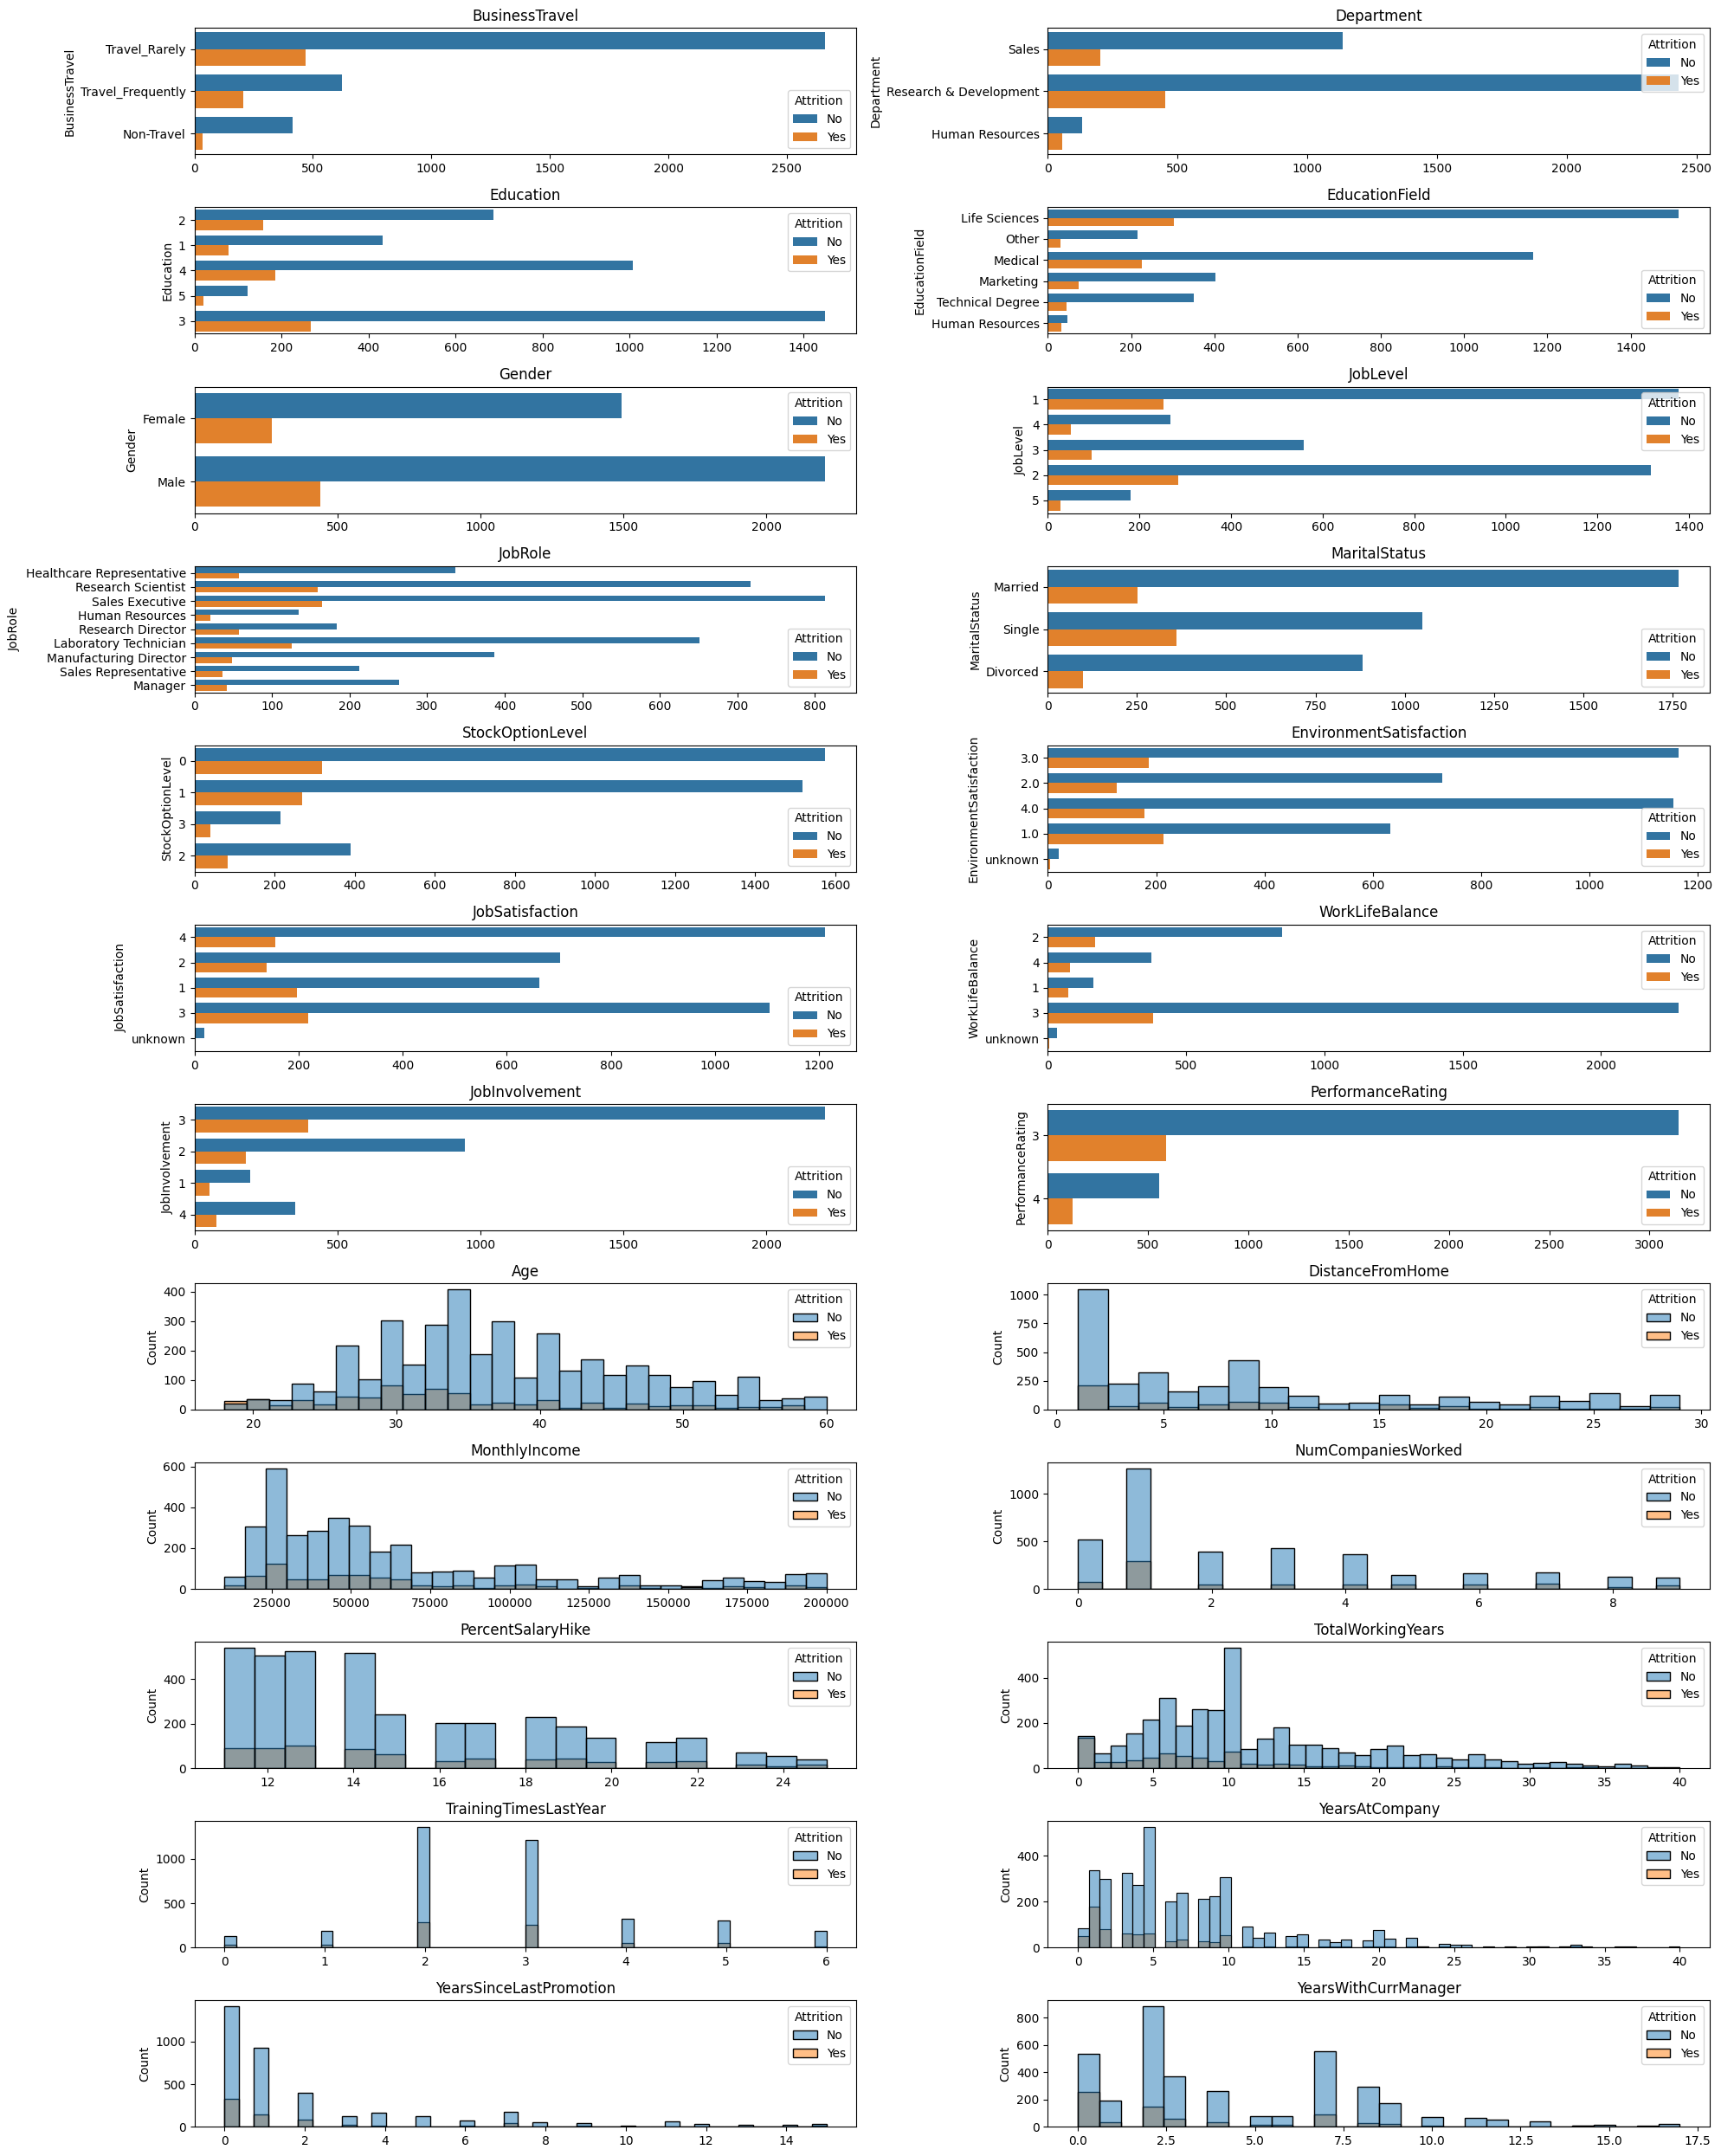

In [133]:
plot_rv_dists(df_total, "Attrition", cat_cols=cat_cols, num_cols=num_cols)

Vemos claramente el desbalanceo de nuestros datos, el cual tendremos que gestionar durante el preprocesamiento. Para las numéricas también podemos analizar visualmente la distribución de los outliers con boxplots:

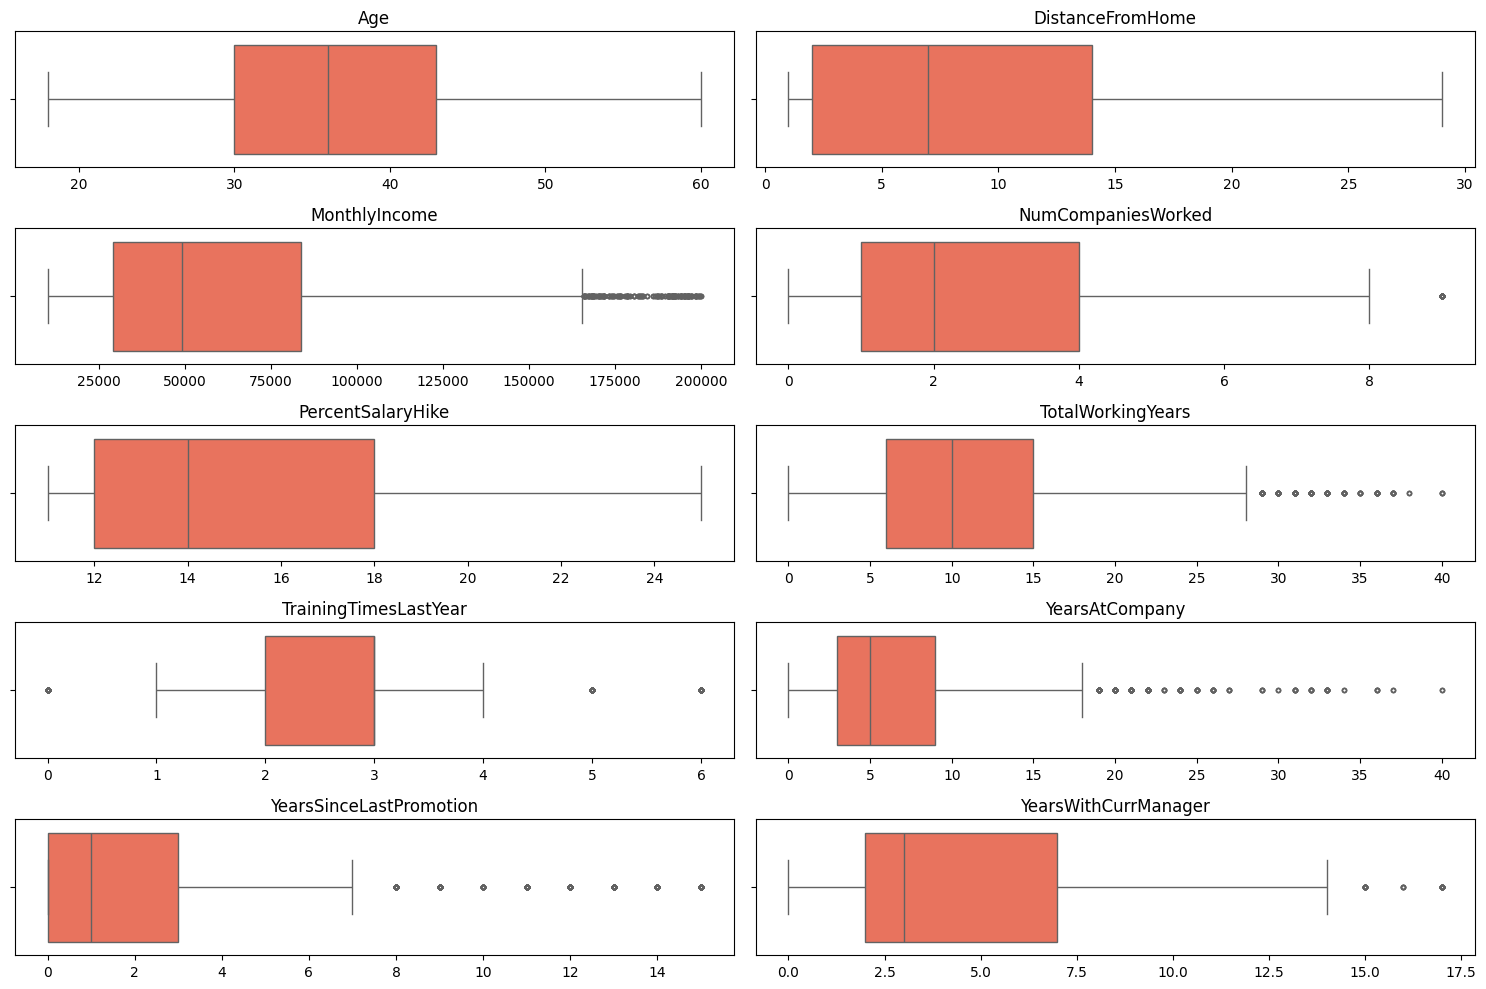

In [134]:
fig, axes = plt.subplots(ncols = 2, nrows = math.ceil(len(num_cols)/2), figsize = (15,10))
axes = axes.flat
for i, col in enumerate(num_cols):
    axes[i].set_title(col)
    sns.boxplot(data = df_total, x = col, ax = axes[i], color = "tomato", flierprops = {"marker" : "."})
    axes[i].set_xlabel("")
plt.tight_layout()
plt.show()

Vemos que los outliers que encontramos suelen estar más bien agrupados, información útil a la hora de detectarlos más tarde.

<Axes: >

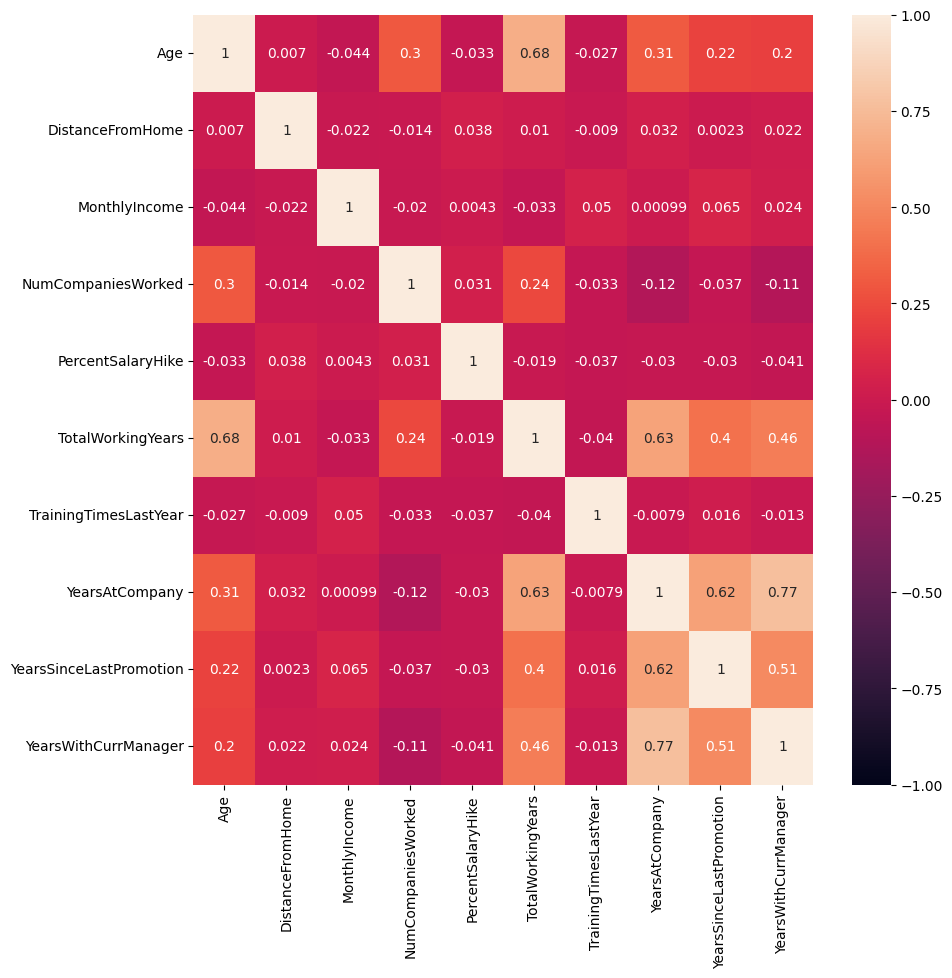

In [135]:
plt.figure(figsize=(10,10))
sns.heatmap(df_total[num_cols].corr(), annot=True, fmt = ".2g", vmin = -1, vmax = 1)

In [136]:
df_total.to_pickle("../datos/clean.pkl")